МИРЭК | 4 модуль

*Автор: Татьяна Рогович*

# Основы программирования в Python
## Cеминар 8

## Предсказываем выживших на Титаникн: выбор лучшей модели

Мы уже немного познакомились с Титаником. Сегодня мы попробуем поучаствовать в тренировочном соревновании на kaggle: посмотрим, как это все в принципе работает, сделаем пару предсказаний (пока без статистических моделей, только на основе здравого смысла).

Чтобы участвовать в соревнованиях и скачивать данные, нужно зарегистрировать профиль на kaggle и залогиниться. Мы сегодня работаем с соревнованием по "Титанику".
https://www.kaggle.com/c/titanic/overview

Скачаем и откроем (или загрузим из ссылок) все три набора данных, которые лежат во вкладке Data.

In [20]:
import pandas as pd
import numpy as np
% matplotlib inline

In [21]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
submission = pd.read_csv('gender.csv')

Инспектируем.
Это датасет, с которым мы уже работали, здесь 891 пассажир и для них мы знаем значение признака Survived.

In [22]:
display(train.head())
display(train.shape)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


(891, 12)

А это так называемая тестовая выборка. В ML мы строим модель на тренировочных данных, для которых знаем значение зависимой переменной, и проверяем качество нашей модели на тестовых данных, для которых мы тоже знаем эту метку, но прячем ее от компьютера. Чтобы потом сравнить, что предсказал алгоритм с реальным значением. В kaggle тестовую метку Survived мы не видим, поэтому, чтобы проверить наше предсказание нам надо загрузить файл на сервер Kaggle, чтобы он его проверил (сравнил ваш ответ с правильным) и выдал вам оценку.

In [23]:
display(test.head())
display(test.shape)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


(418, 11)

В нашем соревновании лежит файл submission example, который показывает вам, как должен выглядеть файл для загрузки. В некоторых соревнованиях все устроено также, а в других вам надо загружать код, который будет обрабатывать скрытую тестовую выборку прямо на сервере.

In [24]:
display(submission.head())
display(submission.shape)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


(418, 2)

Видим, что здесь только две колонки - id пассажира и метка Survived. Обратите внимание, что это пассажиры из тестовой выборки. 

Помните, мы заполняли значение возраста? Одна из наших моделей сегодня будет учитывать возраст. Давайте посмотрим, есть ли пропущенные значения в тестовой выборке.

In [25]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


# Гипотеза 1. Все утонули.

Когда мы начинаем анализ, мы впервую очередь смотрим на распределение нашей целевой (зависимой) переменной. Здесь мы хотим предсказывать Survived.

In [26]:
train['Survived'].value_counts(normalize=True) # параметр normalize сразу выдает нам пропорции, а не абсолютные значения.

0    0.616162
1    0.383838
Name: Survived, dtype: float64

Мы видим, что большинство пассажиров утонуло. Это будет наша baseline model - давайте попробуем сделать предсказание, что все утонули. Baseline нужен для того, чтобы понять, ниже какого предсказания не должны падать ваши модели. Наверное, если ваша модель работает хуже, чем просто "предсказать самый частый класс", то это не лучшая модель. Для количественной целевой переменной самым простым бэйзлайном может быть предсказание медианы и среднего этой переменной для каждого наблюдения.

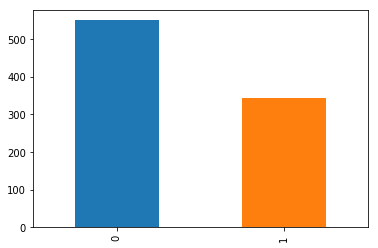

In [27]:
train['Survived'].value_counts().plot(kind='bar')

Чтобы протестировать наше предположение - запишем его в файл и отправим на сервер.

In [28]:
submission['Survived'] = 0 # ставим метку 0 во все ряды

In [29]:
submission.to_csv('alldied.csv', index = False) # если не поставим index = False, то сохраним индекс в отдельную колонку и такой формат файла не пройдет валидатор

Получили оценку! Наш score 0.62679. Для бинарной переменной этой значит, что мы всего в 62% случаев оказались правы. Давайте попробуем улучшить наше предсказание.

# Гипотеза 2. Спасаем женщин.

Если хоть что-то знаете про "Титаник", то наверняка помните историю про "первыми спасаем женщин и детей". Давайте попробуем улучшить наше предсказание, основывая на половом признаке.

In [30]:
train.groupby('Sex')['Survived'].value_counts(normalize=True) #

Sex     Survived
female  1           0.742038
        0           0.257962
male    0           0.811092
        1           0.188908
Name: Survived, dtype: float64

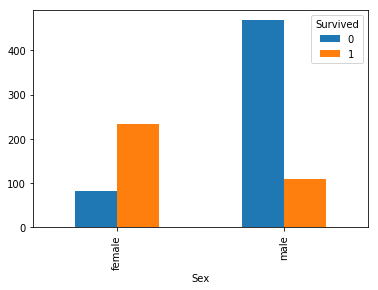

In [31]:
train.groupby('Sex')['Survived'].value_counts().unstack().plot(kind='bar')

Возможно, наше предположение верно. Пропорция выживших женщин больше пропорции выживших мужчин. Перезапишем наш файл.

In [32]:
submission['Survived'] = test['Sex'].apply(lambda x: 1 if x == 'female' else 0)
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [33]:
submission.to_csv('gender.csv', index = False)

0.77! Неплохо, учитывая, что это была совсем простая эвристика. Попробуем еще лучше?


# Гипотеза 3. Женщины и дети

А теперь давайте посмотрим, что там с возрастом.

Survived
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Age, dtype: object

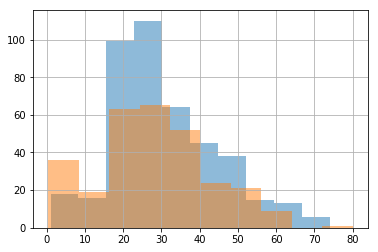

In [34]:
train.groupby('Survived')['Age'].hist(alpha = 0.5, bins = 10) # параметр alpha задает прозрачность графика, bins - размер групп

Тут можно идти по возрастным группам и предполжить, что дети до 10 лет имели больше шансов выжитть, а вот молодые люди от 15 до 30 лет, скорее погибнуть. Но такое сложное условие уже оставим для решающих деревьев, а только скорректируем предсказание для детей младше 10 лет. Заодно посмотрим, как задавать новую переменную через метод библиотеки numpy.where

In [35]:
submission['Survived'] = np.where((test['Sex'] == 'female') | (test['Age'] < 11), 1,0) # в качестве аргументов передаем условие, затем, что делать, если True,
                                                                                        # что делать, если False

In [36]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [37]:
submission.to_csv('gender_child.csv', index = False)

0.77! Еще немного лучше. Давайте теперь попробуем применить к нашим данным алгоритмы машинного обучения и посмотрим, справятся ли они лучше. У нас достаточно серьезный baseline - 77% правильных ответов. Будем стараться преодолеть это значение.

## Предсказываем выживших с помощью ML

Объединяем train и test, для того, чтобы обрабатывать пропущенные значения и создавать признаки. Но разведывательный анализ будем делать только на тренировочной выборке.

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

In [83]:
def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = titanic.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))
    

In [50]:
full = train.append(test, ignore_index = True, sort=False)

del train, test

print ('Datasets:' , 'full:' , full.shape)

Datasets: full: (1309, 12) titanic: (891, 12)


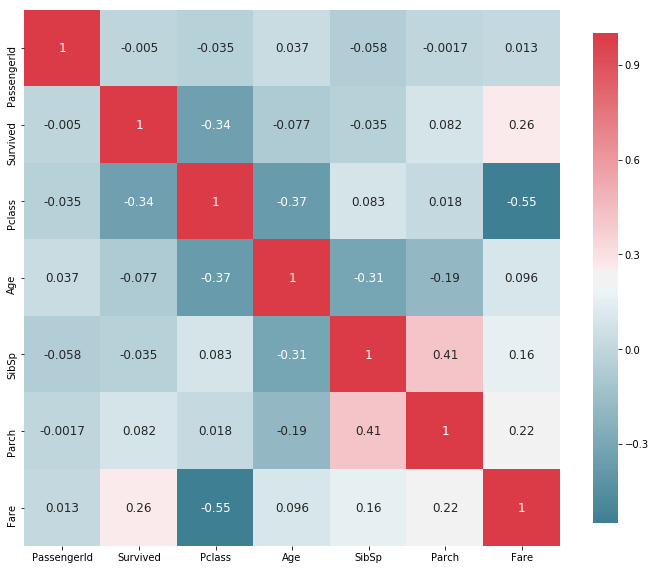

In [51]:
plot_correlation_map(full[:891])

Нет особо сильных корреляций с зависимой переменной, но видим умеренную корреляцию между Fare и Pclass. Пожалуй, выберем из них одну.

# Создание новых переменных: Title

Создадим переменную титул, посмотрим, как она связана с выживанием + используем ее для заполнения пропусков в возрасте.

In [54]:
full['Title'] = full['Name'].map(lambda name: name.split(',')[1].split('.')[0].strip())
full['Title'] = full['Title'].apply(lambda x: x if x in 
                                    ['Mr', 'Miss', 'Mrs', 'Master', 'Rev', 'Dr'] else 'Misc')
full['Title'].value_counts()

Mr        757
Miss      260
Mrs       197
Master     61
Misc       18
Rev         8
Dr          8
Name: Title, dtype: int64

# Заполняем пропуски в Age и Embarked

Теперь используем титул для заполнения пропущенных значений. Опять работаем на всей выборке. Сначала посмотрим, где у нас есть пропущенные значения.

In [34]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
PassengerId    1309 non-null int64
Survived       891 non-null float64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Title          1309 non-null object
dtypes: float64(3), int64(4), object(6)
memory usage: 133.0+ KB


Обработаем пропущенные значения в переменных Age (по титулу), Fare (средним по классу), Embarked (модой).

In [55]:
full['Age'] = full.Age.fillna(full.groupby('Title')['Age'].transform('median'))

In [56]:
full['Fare'] = full.Fare.fillna(full.groupby('Pclass')['Fare'].transform('median'))

In [57]:
full['Embarked'] = full.Embarked.fillna(full['Embarked'].mode()[0])

In [58]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
PassengerId    1309 non-null int64
Survived       891 non-null float64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1309 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1309 non-null float64
Cabin          295 non-null object
Embarked       1309 non-null object
Title          1309 non-null object
dtypes: float64(3), int64(4), object(6)
memory usage: 133.0+ KB


Так же пропуски можно заполнять с помощью алгоритмов машинного обучения - например, попробуйте заполнить пропуски в возрасте с помощью алгоритма kNN, используя все остальные переменные, кроме Survived, чтобы рассчитать расстояние между точками (такой вопрос будет в контрольной).

# Создание новых переменных: размер семьи

Мы тоже уже это делали - складываем горизонтальных и вертикальных родственников, а также учитываем самого пассажира.

In [64]:
full['FamilySize'] = full['Parch'] + full['SibSp'] + 1

А теперь давайте попробуем понять, имеет ли смысл объединить категории.

In [69]:
full[:891].groupby('FamilySize')['Survived'].count()

FamilySize
1     537
2     161
3     102
4      29
5      15
6      22
7      12
8       6
11      7
Name: Survived, dtype: int64

C:\Users\rogov\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


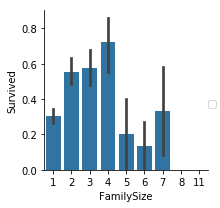

In [71]:
plot_categories(full[:891] , cat = 'FamilySize' , target = 'Survived' )

Мы видим, что в семьях размеров 2-4 процент выживших похож. И нет значительной разницы между семьями больше 5 человек. Давайте используем эту информацию для перекодирования переменных.

In [72]:
full['Family_Single'] = full[ 'FamilySize' ].apply(lambda s: 1 if s == 1 else 0)
full['Family_Small']  = full[ 'FamilySize' ].apply(lambda s: 1 if 2 <= s <= 4 else 0)
full['Family_Large']  = full[ 'FamilySize' ].apply(lambda s: 1 if 5 <= s else 0)

full.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,Family_Single,Family_Small,Family_Large
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,2,0,1,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2,0,1,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1,1,0,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,2,0,1,0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,1,1,0,0


# Подготовка данных
Часть алгоритмов гораздо эффективней работает с переменными, которые закодированы как бинарные. Для этого можно применять метод OneHotEncoding, а можно сделать это методами pandas.

In [73]:
sex = pd.get_dummies(full.Sex , prefix='Sex')
sex.head()

,Sex_female,Sex_male
0,0,1
1,1,0
2,1,0
3,1,0
4,0,1


In [74]:
embarked = pd.get_dummies(full.Embarked , prefix='Embarked' )
embarked.head()

,Embarked_C,Embarked_Q,Embarked_S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


In [75]:
pclass = pd.get_dummies( full.Pclass , prefix='Pclass' )
pclass.head()

,Pclass_1,Pclass_2,Pclass_3
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,0,1


In [76]:
title = pd.get_dummies(full.Title , prefix='Title' )
title.head()

,Title_Dr,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs,Title_Rev
0,0,0,0,0,1,0,0
1,0,0,0,0,0,1,0
2,0,0,0,1,0,0,0
3,0,0,0,0,0,1,0
4,0,0,0,0,1,0,0


# Объединяем датасет
Теперь все наши обработанные переменные объединим в один датасет, а потом разделим его обратно на нашу тренировочную и тестовую выборки.

In [77]:
full_X = pd.concat([full['Age'], embarked, title, full['Family_Single'], full['Family_Small'], full['Family_Large']] , axis=1)
full_X.head()

,Age,Embarked_C,Embarked_Q,Embarked_S,Title_Dr,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs,Title_Rev,Family_Single,Family_Small,Family_Large
0,22.0,0,0,1,0,0,0,0,1,0,0,0,1,0
1,38.0,1,0,0,0,0,0,0,0,1,0,0,1,0
2,26.0,0,0,1,0,0,0,1,0,0,0,1,0,0
3,35.0,0,0,1,0,0,0,0,0,1,0,0,1,0
4,35.0,0,0,1,0,0,0,0,1,0,0,1,0,0


Я не беру оплату за проезд, потому что она коррелирует с классом и пол, потому что он "зашит" в титул.

In [80]:
from sklearn.model_selection import train_test_split

train_valid_X = full_X[:891]
train_valid_y = full[:891].Survived

train_X , test_X , train_y , test_y = train_test_split(train_valid_X , train_valid_y , test_size = 0.3)

print(full_X.shape , train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1309, 14) (623, 14) (623,) (268, 14) (268,)


# Пробуем разные модели

In [81]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

У нас есть функция, которая строит график для важности признаков на основе разбиения DesicionTreeClassifier

0.8860353130016051


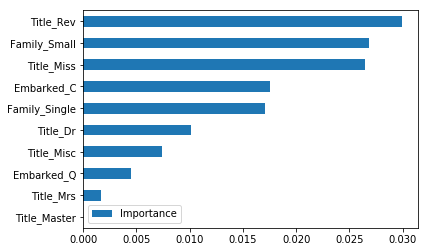

In [82]:
plot_variable_importance(train_X, train_y)

Если вы дальше хотите экспериментировать с добавлением или удалением моделей, то этот график как раз вам поможет.

А теперь как раз перейдем к построению разных моделей. Метрикой ошибки возьмем accuracy, как и в соревновании.

# Кросс-валидация, поиск параметров по сетке, случайный лес

In [84]:
from sklearn.model_selection import cross_validate

In [85]:
model = RandomForestClassifier(n_estimators=100)

Про кросс-валидацию можно подробнее прочитать здесь:
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html

Мы передаем функции cross_validate модель, тренировные x и y, указываем на сколько частей будем разбивать тренировочную выборку, метрику ошибки, и возвращать ли ошибку на тренировочной выборке.

In [86]:
scores = cross_validate(model, train_X, train_y, cv=3, scoring=('accuracy'), return_train_score=True)

In [87]:
scores

{'fit_time': array([0.18627453, 0.18137884, 0.22233415]),
 'score_time': array([0.0129621 , 0.01395917, 0.01498342]),
 'test_score': array([0.75      , 0.77403846, 0.75362319]),
 'train_score': array([0.90120482, 0.91084337, 0.88942308])}

Нас здесь интересует именно test_score - мы смотрим, что она не сильно скачет в зависимости от того, какую часть выборки мы отложили для теста.

In [88]:
np.mean(scores['test_score'])

0.7592205499814195

А вот так в среднем вела себя модель. Давайте попробуем написать функцию которая еще и будет делать подбор параметров по сетке внутри кросс-валидации.

In [89]:
from sklearn.model_selection import GridSearchCV

In [90]:
parameters = {'n_estimators':[10, 50, 100, 200]}
model_cv = GridSearchCV(RandomForestClassifier(), parameters, 
                        cv=3, scoring=('accuracy'), return_train_score=True)

In [91]:
model_cv.fit(train_X, train_y)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': [10, 50, 100, 200]},
             return_train_score=True, scoring='accuracy')

In [118]:
model_cv.cv_results_

{'mean_fit_time': array([0.0269293 , 0.10604914, 0.28557007, 0.36369483]),
 'std_fit_time': array([0.00293653, 0.01316522, 0.16577883, 0.05909422]),
 'mean_score_time': array([0.00132974, 0.00797892, 0.01196758, 0.01928147]),
 'std_score_time': array([0.00047013, 0.00293655, 0.00162898, 0.00329161]),
 'param_n_estimators': masked_array(data=[10, 50, 100, 200],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 10},
  {'n_estimators': 50},
  {'n_estimators': 100},
  {'n_estimators': 200}],
 'split0_test_score': array([0.74038462, 0.73557692, 0.73076923, 0.73076923]),
 'split1_test_score': array([0.76923077, 0.77884615, 0.75480769, 0.75480769]),
 'split2_test_score': array([0.76811594, 0.77294686, 0.77294686, 0.76811594]),
 'mean_test_score': array([0.75922953, 0.76243981, 0.75280899, 0.75120385]),
 'std_test_score': array([0.01334917, 0.01916957, 0.01727005, 0.01545265]),
 'rank_test_score': array([2, 1, 3, 4

Здесь теперь анализируем иначе. 
Так `'split0_test_score': array([0.73076923, 0.75      , 0.74038462, 0.74038462])` это значения каждого из параметров n_estimators по первой разбивке.
Но не пугайтесь, лучшую модель выбрать несложно - нужно посмотреть на средний score или на ранги (rank_test_score). По рангу понимаем, что лучше всего справился лес с 50 деревьями.

In [92]:
model_cv.cv_results_['rank_test_score']

array([3, 1, 2, 4])

Давайте посмотрим теперь внимательно на среднюю скорось по тестам. То же самое.

In [93]:
model_cv.cv_results_['mean_test_score']

array([0.759267  , 0.76565403, 0.76564629, 0.75921281])

Давайте теперь эту модель проверим на нашей отложенной тестовой выборке.

In [94]:
best_model = RandomForestClassifier(n_estimators=50)

In [95]:
best_model.fit(train_X, train_y)

RandomForestClassifier(n_estimators=50)

In [96]:
from sklearn.metrics import accuracy_score
accuracy_score(best_model.predict(test_X), test_y)

0.746268656716418

Запомнили значение. Чуть позже выберем нашего победителя и отправим его на kaggle.
Напоминаю, что лучшее наше предсказание по baseline модели было 0.77 (все женщины и дети выжили).

# KNN
Давайте теперь попробуем KNN. Тоже с поиском параметров по сетке.

In [97]:
parameters = {'n_neighbors':[3, 5, 10, 15]}
model_cv = GridSearchCV(KNeighborsClassifier(), parameters, 
                        cv=3, scoring=('accuracy'), return_train_score=True)

In [98]:
model_cv.fit(train_X, train_y)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 10, 15]},
             return_train_score=True, scoring='accuracy')

In [99]:
model_cv.cv_results_

{'mean_fit_time': array([0.00629656, 0.00465886, 0.00401306, 0.0066483 ]),
 'std_fit_time': array([0.0033048 , 0.00124711, 0.00083435, 0.00169604]),
 'mean_score_time': array([0.00432412, 0.00400337, 0.00398358, 0.00432054]),
 'std_score_time': array([4.67925130e-04, 1.34438390e-05, 8.18974132e-04, 4.71430981e-04]),
 'param_n_neighbors': masked_array(data=[3, 5, 10, 15],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 3},
  {'n_neighbors': 5},
  {'n_neighbors': 10},
  {'n_neighbors': 15}],
 'split0_test_score': array([0.70192308, 0.73076923, 0.63461538, 0.64903846]),
 'split1_test_score': array([0.73557692, 0.74519231, 0.71153846, 0.68269231]),
 'split2_test_score': array([0.70048309, 0.69082126, 0.74879227, 0.75845411]),
 'mean_test_score': array([0.71266103, 0.72226093, 0.69831537, 0.69672829]),
 'std_test_score': array([0.01621464, 0.02299777, 0.04754106, 0.04575808]),
 'rank_test_score': array([2, 1, 3

Тут уже на кросс-валидации видим, что качество ниже RandomForest, но можем протестировать модель с 3 соседями на тестовой выборке.

In [100]:
best_model = KNeighborsClassifier(n_neighbors=3)
best_model.fit(train_X, train_y)
accuracy_score(best_model.predict(test_X), test_y)

0.7238805970149254

Модель справилась хуже. Идем эксперементировать дальше.

# Логистическая регрессия
Попробуем, наверняка, знакомую вам логистическую регрессию. Она как раз должна здорово работать с бинарным таргетом. Тут будем подбирать параметр регуляризации - алгоритм, который зануляет значения некоторых переменных для более эффективной работы модели.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [101]:
parameters = {'penalty':['l1', 'l2']}
model_cv = GridSearchCV(LogisticRegression(), parameters, 
                        cv=3, scoring=('accuracy'), return_train_score=True)

In [102]:
model_cv.fit(train_X, train_y)

C:\Users\rogov\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rogov\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\rogov\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1302, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\rogov\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\rogov\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTA

GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'penalty': ['l1', 'l2']}, return_train_score=True,
             scoring='accuracy')

In [103]:
model_cv.cv_results_

{'mean_fit_time': array([0.00232553, 0.04737655]),
 'std_fit_time': array([0.00047137, 0.01142082]),
 'mean_score_time': array([0.        , 0.00283066]),
 'std_score_time': array([0.        , 0.00022872]),
 'param_penalty': masked_array(data=['l1', 'l2'],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'penalty': 'l1'}, {'penalty': 'l2'}],
 'split0_test_score': array([       nan, 0.79807692]),
 'split1_test_score': array([       nan, 0.82211538]),
 'split2_test_score': array([       nan, 0.83091787]),
 'mean_test_score': array([       nan, 0.81703673]),
 'std_test_score': array([       nan, 0.01387988]),
 'rank_test_score': array([2, 1]),
 'split0_train_score': array([       nan, 0.82409639]),
 'split1_train_score': array([       nan, 0.81445783]),
 'split2_train_score': array([       nan, 0.81490385]),
 'mean_train_score': array([       nan, 0.81781935]),
 'std_train_score': array([       nan, 0.00444226])}

Наконец-то пробили 80%. Видим, что логистическая регрессия со штрафом l2 справилась лучше, давайте ее и проверим на отложенной выборке.

In [108]:
best_model = LogisticRegression(penalty = 'l2')
best_model.fit(train_X, train_y)
accuracy_score(best_model.predict(test_X), test_y)

C:\Users\rogov\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8432835820895522

# Градиентный бустинг
Последний классификатор, на который сегодня посмотрим - градиентный бустинг. Как и случайный лес - это ансанбль (делает предсказание на основании многих алгоритмов). Как случайный лес, использует решающие деревья. Главное отличие в том, что случайный лес строит много-много деревеьев, а потом выбирает предсказание из них за счет голосования или усредняя непрерывное предсказание. Градиентный бустинг строит по одному дереву, для каждого из них считает ошибку и каждым последующим деревом пытается минимизировать ошибку предыдущего. Давайте посмотрим, как он справится здесь.

https://www.datasciencecentral.com/profiles/blogs/decision-tree-vs-random-forest-vs-boosted-trees-explained

In [109]:
scores = cross_validate(GradientBoostingClassifier(), train_X, train_y, cv=3, scoring=('accuracy'), return_train_score=True)
scores

{'fit_time': array([0.11771512, 0.11326528, 0.11671805]),
 'score_time': array([0.00299263, 0.00199533, 0.0019958 ]),
 'test_score': array([0.79326923, 0.79807692, 0.81642512]),
 'train_score': array([0.8626506 , 0.83855422, 0.83653846])}

In [110]:
best_model = GradientBoostingClassifier()
best_model.fit(train_X, train_y)
accuracy_score(best_model.predict(test_X), test_y)

0.8283582089552238

# Kaggle Submission

Все равно хуже, чем логистическая регрессия. Давайте сгенерируем для нее предсказание и проверим его на kaggle.

In [112]:
model = LogisticRegression(penalty = 'l2')
test_X = full_X[891:]
model.fit(train_valid_X, train_valid_y)
pred = model.predict(test_X)
test = pd.DataFrame({'PassengerId': full[891:].PassengerId , 'Survived': pred})
test['Survived'] = test['Survived'].apply(lambda x: int(x))
print(test.shape)
test.head()


(418, 2)


C:\Users\rogov\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,PassengerId,Survived
891,892,0
892,893,1
893,894,0
894,895,0
895,896,1


In [113]:
test.to_csv('titanic_pred_lr.csv' , index = False )

На тестовой выборке kaggle получили 78% - хуже чем для нашего эксперимента, но лучше baseline (небольшая, но победа). Если вы хотите дальше развиваться в машинном обучении - kaggle это отличное место, чтобы обрабатывать полученные навыки.